# Preprocessing pipeline


This pipeline aims to serve as a semiautomatic and reproducible framework for preprocessing EEG signals before performing time-frequency-based analysis. It minimizes the manual steps required to clean the data based on visual inspection. It is advised to revisit the cleaned epochs before writing the final preprocessed file. 


## Outline

1. __Temporal filtering__

High-frequency artefacts and slow drifts are removed with a zero-phase bandpass filter using mne-Python [1]. The cutoff frequencies (0.5 - 45 Hz) can be modified in the utils folder in the configuration file (config.py). 


2. __Create epochs__ 

Epochs are nonoverlapping data segments created from the continuous data with a duration of 1 seconds. The length of epochs can be changed in the configuration file.
Epochs can be created from (1) events; there is a custom method that created epochs based on annotations in the raw data, (2) without events, data segments are created from the beginning of the raw data. 


3. __Outlier data rejection__  

    3.1. _Preliminar rejection_  
Epochs are rejected based on a global threshold on the z-score (> 3) of the epoch variance and amplitude range.

    3.2. _ICA decomposition_  
The default method is the infomax algorithm, however it can be changed in the configuration file along with the number of components and the decimation parameter. Components containing blink artefacts are automatically marked with mne-Python.
The ICA sourced can be visualized and interactively selected and rejected based on their topographies, time-courses or frequency spectra. The number of components that were removed from the data are documented in the “description” field of the epochs instance “info” structure.

    3.3. _Autoreject_  
Autoreject [2, 3] uses unsupervised learning to estimate the rejection threshold for the epochs. In order to reduce computation time that increases with the number of segments and channels, autoreject can be fitted on a representative subset of epochs (25% of total epochs). Once the parameters are learned, the solution can be applied to any data that contains channels that were used during fit.


4. __Outlier channel interpolation__

The Random Sample Consensus (RANSAC) algorithm [4] selects a random subsample of good channels to make predictions of each channel in small non-overlapping 4 seconds long time windows. It uses a method of spherical splines (Perrin et al., 1989) to interpolate the bad sensors. The sensors that were interpolated are added to the "description" field of the epochs "info" structure. 


<img src="static/preprocessing_pipeline_diagram.svg">


## References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.



## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower);    

switch to ```%matplotlib inline``` for (faster) static plots

In [1]:
import os
from ipyfilechooser import FileChooser

from meeg_tools.preprocessing import *
from meeg_tools.utils.epochs import create_epochs_from_events
from meeg_tools.utils.raw import read_raw_measurement, filter_raw
from meeg_tools.utils.log import update_log

from meeg_tools.utils.config import settings

from matplotlib import pyplot as plt
%matplotlib qt

## Load raw data


See [this](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html) documentation for help with supported file formats.  

In [3]:
# Use the widget to navigate to the experiment folder path and select an EEG file 
base_path = '/Volumes/crnl-memo-hd/TMS_rewiring/'
fc = FileChooser(base_path)
fc.filter_pattern = ['*.vhdr', '*.edf']

display(fc)

FileChooser(path='/Volumes/crnl-memo-hd/TMS_rewiring', filename='', title='HTML(value='', layout=Layout(displa…

In [6]:
# Load selected file
raw = read_raw_measurement(raw_file_path=fc.selected)
raw.info

Extracting parameters from /Volumes/crnl-memo-hd/TMS_rewiring/Raw_data/30_E/Day1/EEG/30_E_Day1.vhdr...
Setting channel info structure...


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 fid: 30_E_Day1
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2020-11-23 14:34:34 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
>

## Temporal filtering

- bandpass filter (0.5 - 45 Hz)

In [7]:
settings['bandpass_filter']

{'low_freq': 0.5, 'high_freq': 45}

In [8]:
raw_bandpass = filter_raw(raw)

Reading 0 ... 2916579  =      0.000 ...  5833.158 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   17.6s
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:   46.5s finished


## Create epochs

- select the events for analysis

In [9]:
settings['epochs']['start_time'] = -0.25
settings['epochs']['end_time'] = 0.75

In [10]:
events_ids = np.concatenate([np.arange(10, 53, 1), 
                             np.arange(10, 53, 1) + 100,
                            [211, 212, 213, 214, 215, 216]])

epochs = create_epochs_from_events(raw=raw_bandpass, event_ids=[events_ids])

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 19', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28', 'Stimulus/S 29', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 36', 'Stimulus/S 37', 'Stimulus/S 38', 'Stimulus/S 39', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 44', 'Stimulus/S 45', 'Stimulus/S 46', 'Stimulus/S 47', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S 61', 'Stimulus/S 62', 'Stimulus/S 63', 'Stimulus/S 64', 'Stimulus/S 65', 'Stimulus/S 66', 'Stimulus/S 67', 'Stimulus/S 68', 'Stimulus/S 69', 'Stimulus/S 70', 'Stimulus/S 71', 'Stimulus/S 72', 'Stimulus/S 75', 'Stimulus/S 77', 'Stimulus/S 78', 'Stimulus/S 80', 

## Create metadata for epochs (optional)

- adding metadata makes it easier to select epochs of different types
- custom triggers are selected from the raw instance

- metadata can be added or replaced later (e.g. after preprocessing)

In [11]:
import pandas as pd

metadata = pd.DataFrame(data=epochs.events, columns=['time_in_samples', 'stim', 'id'])
metadata.head(10)

,time_in_samples,stim,id
0,566211,0,46
1,572660,0,46
2,574991,0,46
3,575160,0,19
4,575366,0,42
5,575527,0,29
6,575919,0,19
7,576140,0,42
8,576286,0,29
9,576678,0,19


In [12]:
# we can add boundaries of epochs
epoch_boundaries = [211, 212, 213, 214, 215, 216]

edges = np.where(np.isin(epochs.events
                         [..., 2], epoch_boundaries))[0]
for epoch_ind, epoch in enumerate(np.split(epochs.events, edges, axis=0)):
    if epoch_ind != len(edges):
        metadata.loc[metadata['time_in_samples'].isin(epoch[...,0]), 'epoch'] = epoch_ind + 1

In [13]:
metadata.loc[metadata['id'].isin([10, 110, 11, 111, 14, 114, 15, 115]), 'triplet'] = 'H'
metadata.loc[metadata['id'].isin([12, 112, 13, 113, 16, 116,  112, 113, 116]), 'triplet'] = 'L'
metadata.loc[metadata['id'].isin([10, 110, 14, 114],), 'triplet_type'] = 'HR'
metadata.loc[metadata['id'].isin([12, 112, 16, 116],), 'triplet_type'] = 'LR'
metadata.loc[metadata['id'].isin([11, 13, 15, 111, 113, 115],), 'triplet_type'] = 'P'
metadata.loc[metadata['id'].isin([44, 45, 46, 47, 144, 145, 146, 147]), 'answer'] = 'incorrect'
metadata.loc[~metadata['id'].isin([44, 45, 46, 47, 144, 145, 146, 147]), 'answer'] = 'correct'


# find stimuli that are followed by an incorrect answer
stimuli = metadata[metadata['id'].isin([10, 110, 11, 111, 12, 112, 13, 113, 14, 114, 15, 115, 16, 116])]
stimuli_indices = np.asarray(stimuli['id'].index.tolist())
incorrect_indices = np.asarray(metadata.index[metadata['answer'] == 'incorrect'].tolist()) -1
incorrect_answers = stimuli_indices[np.isin(stimuli_indices, incorrect_indices)]
metadata.loc[incorrect_answers, 'answer'] = 'incorrect'

# df.loc[df['id'].isin([10, 110, 14, 114],), 'triplet_type'] = 'HR'
# df.loc[df['id'].isin([12, 112, 16, 116],), 'triplet_type'] = 'LR'
# df.loc[df['id'].isin([11, 13, 15, 111, 113, 115],), 'triplet_type'] = 'P'
# df.loc[df['id'].isin([10,11,12,13,14,15,16],), 'sequence'] = 'A'
# df.loc[df['id'].isin([100,111,112,113,114,115,116],), 'sequence'] = 'B'

epochs.metadata = metadata


Adding metadata with 6 columns


In [ ]:
# we can filter epochs as a query
epochs["triplet == 'H' & answer == 'incorrect'"]

In [ ]:
epochs["epoch == 5 & triplet == 'L'"]

In [14]:
# subselecting epochs 
# Here we could also include thrills, repetitions, or practice stimuli.
# ICA should not run on duplicate data (epochs should not be overlapping!)

epochs = epochs["triplet == 'L' | triplet == 'H'"]

## Run preprocessing


### 1.1. Preliminary epoch rejection

In [15]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Loading data for 1684 events and 501 original time points ...
0 bad epochs dropped
Bad epochs by amplitude
	[1106 1194 1260 1425 1457 1649]
Bad epochs by deviation
	[   7   46  134  163  212  401  571  576  589  590  606  646  684  735
  761  940  991  992  993 1075 1102 1105 1106 1107 1122 1139 1194 1195
 1257 1260 1267 1272 1290 1291 1374 1376 1377 1391 1415 1416 1426 1427
 1428 1430 1452 1456 1457 1479 1480 1649 1650 1678 1680]
Bad epochs by variance
	[ 591  606  646 1076 1106 1194 1260 1291 1385 1391 1425 1477 1478 1479
 1649]
Dropped 59 epochs: 7, 46, 134, 163, 212, 401, 571, 576, 589, 590, 591, 606, 646, 684, 735, 761, 940, 991, 992, 993, 1075, 1076, 1102, 1105, 1106, 1107, 1122, 1139, 1194, 1195, 1257, 1260, 1267, 1272, 1290, 1291, 1374, 1376, 1377, 1385, 1391, 1415, 1416, 1425, 1426, 1427, 1428, 1430, 1452, 1456, 1457, 1477, 1478, 1479, 1480, 1649, 1650, 1678, 1680


### 1.2. Run ICA


The parameters are: 32 ICA components using ["infomax"](https://mne.tools/stable/generated/mne.preprocessing.infomax.html) algorithm. 

When visualizing the components, it is recommended to subset the data (see below).

In [16]:
ica = run_ica(epochs=epochs_faster)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Loading data for 1625 events and 501 original time points ...
Selecting by number: 32 components
 


/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/mne/preprocessing/infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Loading data for 1625 events and 501 original time points ...
Fitting ICA took 195.4s.
EOG channels are not found. Attempting to use Fp1,Fp2 channels as EOG channels.
Loading data for 1625 events and 501 original time points ...
Loading data for 1625 events and 501 original time points ...
Loading data for 1625 events and 501 original time points ...
Loading data for 1625 events and 501 original time points ...


In [ ]:
# Plot component topographies
ica.plot_components()

Loading data for 446 events and 501 original time points ...
Not setting metadata
Not setting metadata
446 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


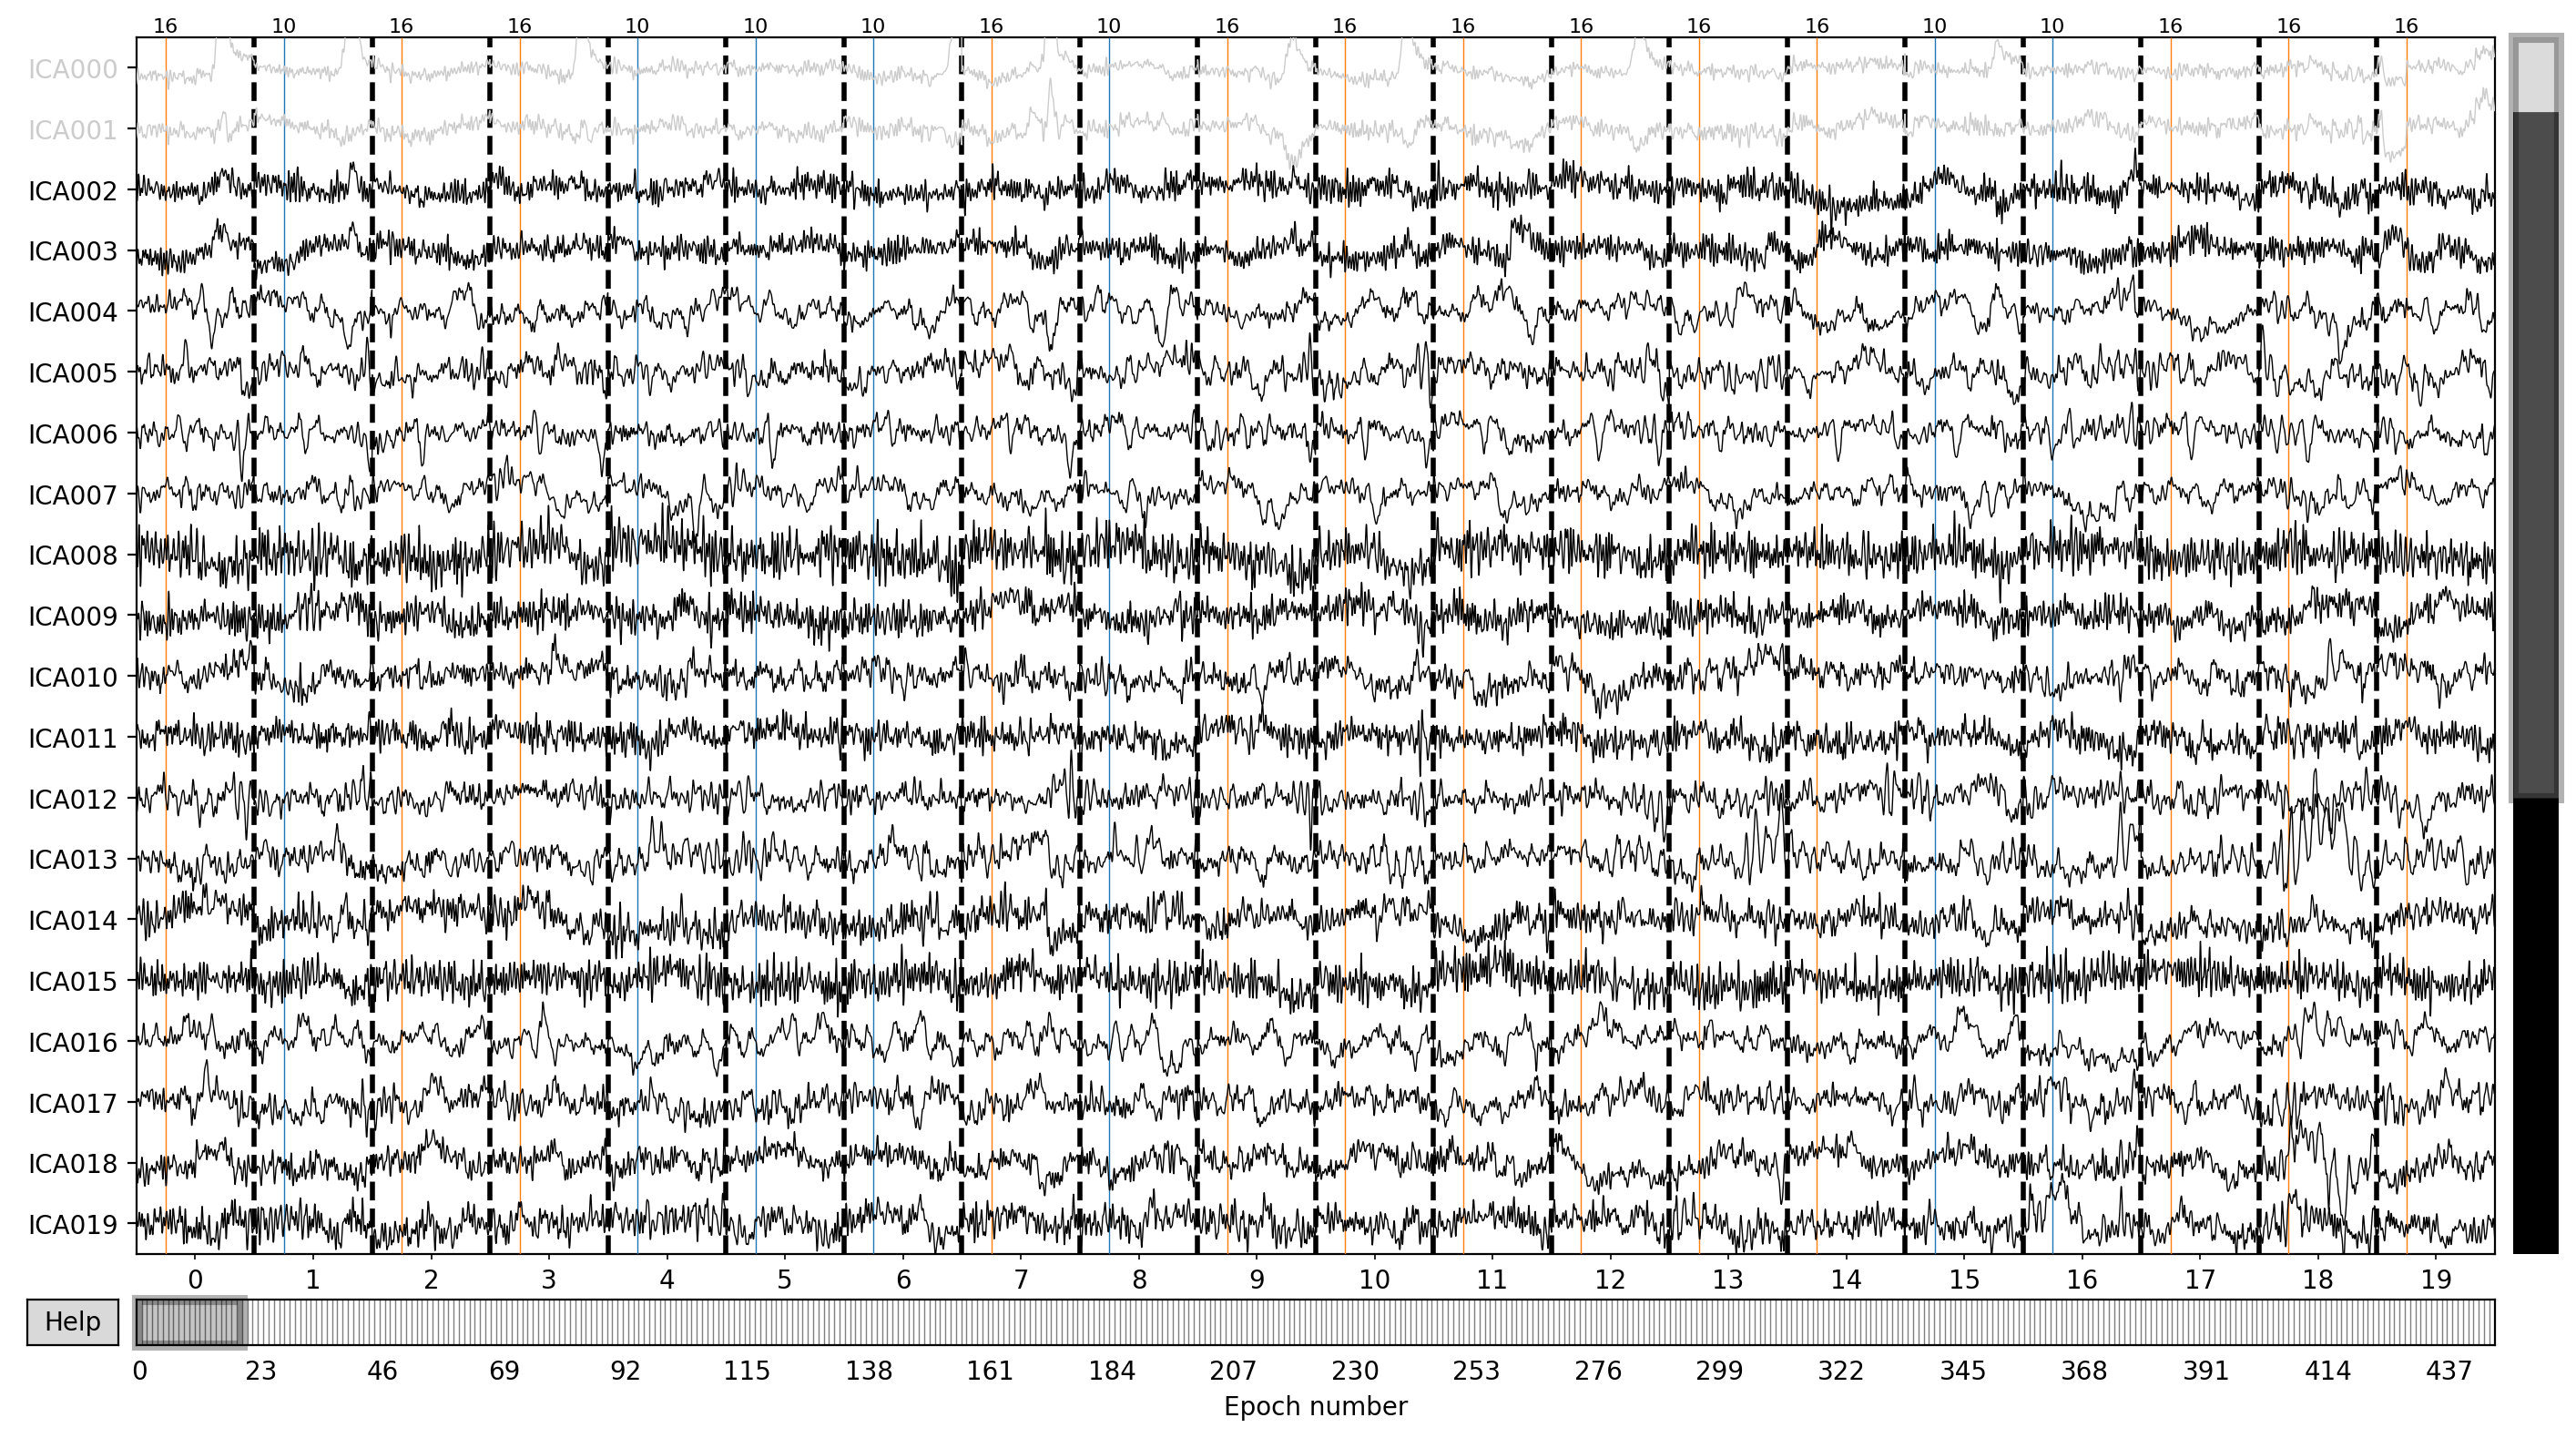

In [17]:
# Visualize components on epochs
# Subset epochs to reduce execution time (e.g. take epochs from every 5th event)
subset = list(epochs.event_id.keys())[::5]
# Exclude components by selecting them, right click on component name to visulize source:
ica.plot_sources(epochs_faster[subset])

In [18]:
# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster.load_data())
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

Loading data for 1625 events and 501 original time points ...
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 

In [ ]:
# Optional
epochs_faster[subset].plot(n_epochs=10, n_channels=32, scalings={'eeg': 20e-6},)


In [ ]:
# Optional
# If you found a component that should have been excluded but it wasn't you can exclude it here:
ica.plot_sources(epochs_faster)

# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster)
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

### 1.4. Save cleaned epochs (recommended)

In [ ]:
# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
epochs_path = os.path.join(base_path, folder_name, 'epochs_asrt')


# Create path to epoch files
if not os.path.exists(epochs_path):
    os.makedirs(epochs_path)

# Save ICA cleaned epochs 
# LOG file needs this to be updated!!!
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_faster.save(os.path.join(epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_faster.info

### 1.5. Create a log file 

We can create a log file for the preprocessed data and store metadata
that could be useful to remember. You can add more columns to this, or 
remove the ones that are not needed. For documentation purporses, it is 
recommended to store the number of rejected and total epochs, the number of
ICA components that were rejected, the number of interpolated electrodes etc.
You can also add a column with "notes" to add custom descriptions about the data.

In [23]:
update_log(os.path.join(os.path.join(base_path, 'preprocessed', 'epochs_asrt'), 'log.csv'), epochs_faster, '')

In [ ]:
# Create a preprocessing log file
log_file_path = os.path.join(epochs_path, 'log.csv')

subject, condition, day = fid.split('_')

n_bad_epochs = len([drop for drop in epochs_faster.drop_log if 'FASTER' in drop or 'USER' in drop])

log = pd.DataFrame({'subject': [subject],
                    'condition': [condition],
                    'day': [day],
                    'fid': [epochs_clean_fname],
                    'highpass': [epochs_faster.info['highpass']],
                    'lowpass': [epochs_faster.info['lowpass']],
                    'n_components': [len(ica.exclude)],
                    'n_bad_epochs': [n_bad_epochs],
                    'n_total_epochs': [len(epochs)],
                    'drop_percentage': [round(epochs_faster.drop_log_stats(), 2)],
                    'stimuli': [list(epochs_faster.event_id.keys())],
                    't_min': [epochs_faster.tmin],
                    't_max': [epochs_faster.tmax],
                    'n_interpolated': [np.NaN],
                    'baseline': [np.NaN],
                    'notes': ['']})


if os.path.isfile(log_file_path):
    log.to_csv(log_file_path, mode='a', index=False, header=False)
else:
    log.to_csv(log_file_path, index=False)

In [ ]:
log

### 2.1. Run autoreject

In [ ]:
reject_log = run_autoreject(epochs_faster.load_data(), n_jobs=11, subset=True)

In [ ]:
# Here you can decide how strict should be the epoch rejection.
# You can drop only those that were marked as bad epochs, or a more 
# strict rejection threshold can be if you drop epochs where more than
# 15% of the channels were marked as noisy.

# You can plot the epochs with Autoreject, where bad epochs are marked with
# red colors. 

# reject_log.plot_epochs(epochs_faster)


# rejecting only bad epochs
# epochs_autoreject = epochs_faster.copy().drop(reject_log.bad_epochs, reason='AUTOREJECT')

# rejecting those epochs too where more than 15% of the channels are marked as noisy
bads = np.where(np.count_nonzero(reject_log.labels, axis=1) > 0.15 * epochs_faster.info['nchan'])[0].tolist()

# you can plot just the bad epochs to double check how strict this rejection is
# if bads: 
#     epochs_faster[bads].plot(n_epochs=10,
#                                 scalings={'eeg': 20e-6},
#                                 n_channels=32)


epochs_autoreject = epochs_faster.copy().drop(bads, reason='AUTOREJECT')

In [ ]:
epochs_autoreject.plot(n_epochs=10, n_channels=32, scalings={'eeg': 20e-6},)

In [ ]:
# save clean epochs
fid = epochs_autoreject.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
# we can update the log file here, or at the end

n_bad_epochs += len([drop for drop in epochs_autoreject.drop_log if 'AUTOREJECT' in drop or 'USER' in drop])

log['fid'].update(epochs_clean_fname)
log['n_bad_epochs'].update(n_bad_epochs)
log['drop_percentage'].update(round(epochs_autoreject.drop_log_stats(), 2))

In [ ]:
if os.path.isfile(log_file_path):
    log.to_csv(log_file_path, mode='a', index=False, header=False)
else:
    log.to_csv(log_file_path, index=False)

### 3. Run ransac

In [ ]:
ransac = run_ransac(epochs)

In [ ]:
epochs_ransac = epochs_autoreject.copy()
epochs_ransac.info['bads'] = ransac.bad_chs_
# Alternatively, you can interpolate the channels that were reported before 
# epochs_ransac.info['bads'] = ransac.report

epochs_ransac.interpolate_bads(reset_bads=True)

In [ ]:
dict_1 = {'FT9': 0.09, 'T7': 0.29, 'T8': 0.09, 'FT10': 0.06, 'F8': 0.08}

print("\n".join("{}\t{}".format(k, v) for k, v in dict_1.items()))

In [ ]:
{k: v for k, v in sorted(dict_1.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
ransac.report = dict_1

In [ ]:
ransac.report

In [ ]:
ransac.bad_log.shape

In [ ]:
# inspect which sensors were interpolated (if any)
epochs_ransac.info

In [ ]:
interpolated_electrodes = epochs_ransac.info['description'].replace(' ', '').replace(':', '').split('interpolated')[1]
print(interpolated_electrodes.split(','))
if interpolated_electrodes:
    log['n_interpolated'] = len(interpolated_electrodes.split(','))
else:
    log['n_interpolated'] = 0

In [ ]:
log

## 4. Final visual inspection

Mark epochs that should be dropped,  etc.

In [ ]:
epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
# If there were no bad channels found, however there are clearly some bad ones
# you can you the epochs_ransac object to mark bad channels

# example
# epochs_ransac.info['bads'] = ['Fp1', 'F7']
# epochs_ransac.interpolate_bads()
# bads_str = ', '.join(['Fp1', 'F7'])
# epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
# log['n_interpolated'].update(len(['Fp1', 'F7']))


# However, if you found additional channels (addition to those that were found with RANSAC)
# then you should use the epochs_autoreject object (don't interpolate the same object twice)

# example
# epochs_ransac = epochs_autoreject.copy()
# epochs_ransac.info['bads'] = ['Fp1', 'F7']
# bads_str = ', '.join(['Fp1', 'F7'])
# epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
# log['n_interpolated'].update(len(['Fp1', 'F7']))


## 5. Apply baseline and set average reference

### 5.1. Apply baseline (optional)



In [ ]:
epochs_ransac.apply_baseline(baseline=(-0.25, 0.0))

### 5.2. Set average reference

To set a “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'.

In [ ]:
epochs_ransac.set_eeg_reference('average')

## 6. Save cleaned epochs

In [ ]:
# save clean epochs
fid = epochs_ransac.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac.save(os.path.join(epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
n_bad_epochs += len([drop for drop in epochs_ransac.drop_log if 'USER' in drop])

log['n_bad_epochs'].update(n_bad_epochs)
log['drop_percentage'].update(round(epochs_ransac.drop_log_stats(), 2))

log['fid'].update(epochs_clean_fname)
log['baseline'] = [epochs_ransac.baseline]

In [ ]:
log

In [ ]:
if os.path.isfile(log_file_path):
    log.to_csv(log_file_path, mode='a', index=False, header=False)
else:
    log.to_csv(log_file_path, index=False)

## Time-frequency analysis
### Evoked


In [ ]:
# Subset channels

ch_names = ['F7', 'F5', 'F3', 'FC5', 'FC3',
           'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2',
           'F4', 'F6', 'F8', 'FC4', 'FC6',
           'FT7', 'T7', 'TP7', 
           'C3', 'Cz', 'C4',
           'FT8', 'T8', 'TP8',
           'CP5', 'CP3', 'P7', 'P5', 'P3',
           'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2',
           'CP4', 'CP6', 'P4', 'P6', 'P8',
           'PO3', 'PO7', 'O1',
           'PO4', 'PO8', 'O2',]

epochs_evoked = epochs_ransac.copy().pick_channels(ch_names, ordered=True)

In [ ]:
fig = epochs_evoked.plot_sensors(show_names=True)

In [ ]:
epochs_evoked.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
#bands = [(4, 8, 'Theta (4 - 8 Hz)'), (8, 13, 'Alpha (8 - 13 Hz)'), (13, 30, 'Beta (13 - 30 Hz)'), (30, 45, 'Gamma (30 - 45 Hz)')]
#epochs_ransac_ordered.plot_psd_topomap(bands=bands, vlim='joint', ch_type='eeg')

In [ ]:
evoked_epoch_1_H = epochs_evoked["epoch == 1 & triplet == 'H'"].average()

In [ ]:
evoked_epoch_1_H.detrend().plot()

In [ ]:
epochs_evoked.detrend().plot_joint(times=[0.0, 0.11, 0.15, 0.3, 0.6, 0.7])

In [ ]:
epochs_evoked["epoch == 1 & triplet == 'H'"].plot_psd()

In [ ]:
# cleanup from memory
del all

plt.close('all')